## Calibration to WC's infection growth during first 12 days (before lockdown)

- read in empirical data and then match simulated data via Nelder–Mead method

In [1]:
# This reads in all parameters (certain and uncertain) and all required packages 

In [5]:
 "First, set the path to find src and import packages"
from __future__ import print_function
import psutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os 
import re
from pathlib import Path

# root = '/Users/admin/git_repos/sabcom/' #CHANGE ROOT FOR HPC CLUSTER
# sys.path.append(root)
root=""

from src.environment import EnvironmentNetwork
from src.runner import Runner
from src.callib.indirect_calibration import *
import networkx as nx
import json
import random
import time

from multiprocessing import Pool 

#LOAD DEFAULT PARAMS 

experiment_dir = ''
with open(root+experiment_dir+'parameters.json') as json_file:
    parameters = json.load(json_file)
with open(root+experiment_dir+'neighbourhood_data.json') as json_file:
    neighbourhood_data = json.load(json_file)
    
#Get empirical data
real = pd.read_excel('./src/callib/confirmed.xlsx')
empirical = real.growth[1:].values[:12]

empirical_moments = np.array([empirical.mean(), empirical.var()])
print("empirical_moments=",empirical_moments) #-> these will be hardcoded in check_model_performance(), todo!

empirical_moments= [1.32350581 0.03317464]


This runs the algorithm, measurement is a bit awkward - to be improved!

In [7]:

np.seterr(all='ignore')
start = time.time()

# !!!!!!!! IMPORTANT Be aware of the parameter you are passing in
problem = {'num_vars': 2,
           'names': ['probability_transmission', 'share_inital_agents_infected' ], 
           'bounds': [[0.2, 0.6], [0.05, 0.3]]}

uncertain_parameters = [0.4, 0.2] #For testing!!! # todo!

# Bounds
LB = [x[0] for x in problem['bounds']]
UB = [x[1] for x in problem['bounds']]

#This will then need to be done in simulate_model_uncertainparams (how can I pass this in? )
# storage_info =  str(params['probability_transmission']) + " and " +str(params['share_inital_agents_infected'])


def simulate_model_uncertainparams(seed_params):
    """Simulates the model for a single seed and outputs the associated cost"""
    seed = seed_params[0]
    params = seed_params[1] # updated complete parameter set with certain and uncertain params 
    np.random.seed(seed)
    random.seed(seed)  
    # # # # # # # # # # # # # # # # # # # # # #  # # # # # # # # # # # # # # # # # # # # # # 
#     This is important for measurement!!!!! you have to know which params are uncertain (hardcoded - todo!)
#    # # # # # # # # # # # # # # # # # # # # # #   # # # # # # # # # # # # # # # # # # # # # # 
    policy = "baseline" 
    storage_info = str(params['probability_transmission']) + " and " +str(params['share_inital_agents_infected'])
    #   # # # # # # # # # # # # # # # # # # # # # #  # # # # # # # # # # # # # # # # # # # # # # 
   
    #Make folders  
    if not os.path.exists('measurement/baseline/'+storage_info+'/seed{}'.format(seed)):  #Create for storage
        os.makedirs('measurement/baseline/'+storage_info+'/seed{}'.format(seed))
    # # # # # # # # # # # # # # # # # # # # # # 

    age_distribution = pd.read_csv('age_dist.csv', sep=';', index_col=0)
    age_distribution_per_ward = dict(age_distribution.transpose())
    
    environment = EnvironmentNetwork(seed, params, neighbourhood_data, age_distribution_per_ward) # pass in params,not parameters
    
    runner = Runner()
    if policy=="baseline":
        runner.baseline_value(str(storage_info), environment, seed)   
   
    # OUTPUT HANDLING     # # # # # # # # # # # # # # # # # # # # # #     # # # # # # # # # # # # # # # # # # # # # # 
    ouput = {}
    print("params",storage_info)
    for subdir, dirs, files in os.walk('./measurement/baseline/'+str(storage_info)+'/'):
        if 'seed' in subdir:
            id=str(seed_params[0])
            temp = []
            for file in files:
                if 'csv' in file:
#                     print(file+' read')
                    df = pd.read_csv(subdir+'/'+file)
                    x = re.findall(r'\d+',file)
                    df['time'] = x[0]
                    df['seed']=id
                    temp.append(df)

            data_per_run=pd.concat(temp)
            data_per_run['params']=str(storage_info)  
            for elem in data_per_run.status.unique():
                data_per_run[str(elem)] = data_per_run.status == elem
                data_per_run[str(elem)] = data_per_run[str(elem)] *1
            df1=data_per_run.sort_values(by=['seed','time', 'agent'])
            
            try:
                df1=df1[['time', 's', 'i1', 'i2', 'r','d', 'c','status', "params"]]
            except:
                print('had NO DEATHS!')
                df1['d'] = 0  # add death columns 
                df1=df1[['time', 's', 'i1', 'i2', 'r','d', 'c','status', "params"]]
            
            df1=df1.groupby('time').sum()
            df1['infected'] = df1.i1 + df1.i2 + df1.c
            df1['growth'] = df1['infected'].pct_change() +1
            data=df1.reset_index()
            ouput[str(storage_info)] = data
#     print('finished '+str(storage_info))   
    data = data[:12] ## data Only take the first 12 days!!!!  ############################################################

    stylized_facts_sim = np.array([data.growth.mean(), data.growth.var()])
    print("progress:",stylized_facts_sim)
    W = np.identity(len(stylized_facts_sim))
    
    empirical_moments= np.array([1.32350581, 0.03317464])  #hardcoded - improve!! #######################

    cost = quadratic_loss_function(stylized_facts_sim, empirical_moments, W)
    return cost


def pool_handler():
    NRUNS = 1
    # BURN_IN = 62 #+2
    CORES = NRUNS # set the amount of cores equal to the amount of runs
    p = Pool(CORES) # argument is how many process happening in parallel
    list_of_seeds = [x for x in range(NRUNS)]

    def check_model_performance(input_parameters):
        
        # convert relevant parameters to integers
        new_input_params = []
        for idx, par in enumerate(input_parameters):
            new_input_params.append(par)
        # update params
        uncertain_parameters = dict(zip(problem['names'], new_input_params))
        
#       load original parameters from experiment dir
        with open(root+experiment_dir+'parameters.json') as json_file:
            params = json.load(json_file)
        params.update(uncertain_parameters)   # ORIGINAL PARAMETER READ IN 
        with open(root+experiment_dir+'neighbourhood_data.json') as json_file:
            neighbourhood_data = json.load(json_file) # neighborhood doesn't change

        list_of_seeds_params = [[seed, params] for seed in list_of_seeds]
        costs = p.map(simulate_model_uncertainparams, list_of_seeds_params) # first argument is function to execute, second argument is tuple of all inputs TODO uncomment this
        return np.mean(costs)
    
    output = constrNM(check_model_performance, uncertain_parameters, LB, UB, maxiter=20, full_output=True)
    with open('estimated_params.json', 'w') as f:
        json.dump(list(output['xopt']), f)

    print('All outputs are: ', output)
    return output

if __name__ == '__main__':
    output=pool_handler()

    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("The program took "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    print('memory % used:', psutil.virtual_memory()[2]) 
    

params 0.3999999999999999 and 0.19999999999999996
progress: [1.08560268 0.0160607 ]
params 0.46180339887498945 and 0.19999999999999996
progress: [1.07936396 0.01734691]
params 0.3999999999999999 and 0.23771490056035166
progress: [1.07455122 0.01800893]
params 0.46180339887498945 and 0.15967996031662812
progress: [1.10306459 0.02021922]
params 0.4907980999479092 and 0.12095635402307142
progress: [1.12319423 0.01768505]
params 0.43128689300804596 and 0.12095635402307142
progress: [1.11950606 0.01719847]
params 0.5175570504584943 and 0.06385245355377778
progress: [1.19193315 0.02543702]
params 0.5618033988749892 and 0.051870395601718744
progress: [1.2258892  0.02690791]
params 0.5902113032590306 and 0.051870395601718744
progress: [1.21422284 0.02085477]
params 0.5975376681190276 and 0.16243637974934844
progress: [1.10518949 0.02253119]
params 0.5414213562373094 and 0.06385245355377774
progress: [1.19265534 0.02750252]
params 0.5975376681190274 and 0.08987445787010741
progress: [1.1649755 

# Check output curves 

- run the two cells above and then the cell below

['probability_transmission', 'share_inital_agents_infected']
[0.54142136 0.05030579]
folder fitted
progress: [1.22609992 0.03546955]


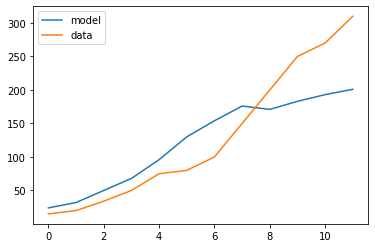

In [39]:
print(problem['names'])
print(output['xopt'])

uncertain_parameters = dict(zip(problem['names'], output['xopt']))

#do a normal run 

with open(root+experiment_dir+'parameters.json') as json_file:
    params = json.load(json_file)
params.update(uncertain_parameters)   # ORIGINAL PARAMETER READ IN 

with open(root+experiment_dir+'neighbourhood_data.json') as json_file:
    neighbourhood_data = json.load(json_file) # neighborhood doesn't change
    
age_distribution = pd.read_csv('age_dist.csv', sep=';', index_col=0)
age_distribution_per_ward = dict(age_distribution.transpose())
seed=0
environment = EnvironmentNetwork(seed, params, neighbourhood_data, age_distribution_per_ward) 

storage_info='fitted'
#Make folders  
if not os.path.exists('measurement/baseline/'+storage_info+'/seed{}'.format(seed)):  #Create for storage
    os.makedirs('measurement/baseline/'+storage_info+'/seed{}'.format(seed))

 # ############  # ############
runner = Runner()
runner.baseline_value(storage_info,environment, seed)
 # ############   # ############
    
ouput = {}
print("folder",storage_info)
for subdir, dirs, files in os.walk('./measurement/baseline/'+storage_info+'/'):
    if 'seed' in subdir:
        id=seed
        temp = []
        for file in files:
            if 'csv' in file:
#                     print(file+' read')
                df = pd.read_csv(subdir+'/'+file)
                x = re.findall(r'\d+',file)
                df['time'] = x[0]
                df['seed']=id
                temp.append(df)
        data_per_run=pd.concat(temp)
        data_per_run['params']=str(storage_info)  
        for elem in data_per_run.status.unique():
            data_per_run[str(elem)] = data_per_run.status == elem
            data_per_run[str(elem)] = data_per_run[str(elem)] *1
        df1=data_per_run.sort_values(by=['seed','time', 'agent'])
        df1=df1[['time', 's', 'i1', 'i2', 'r','d', 'c','status', "params"]]
        df1=df1.groupby('time').sum()
        df1['infected'] = df1.i1 + df1.i2 + df1.c
        df1['growth'] = df1['infected'].pct_change() +1
        data=df1.reset_index()
        ouput[str(storage_info)] = data
 
data = data[:12] ## data Only take the first 12 days!!!!  ############################################################
stylized_facts_sim = np.array([data.growth.mean(), data.growth.var()])
print("progress:",stylized_facts_sim)

plt.plot(data.infected, label='model')
plt.plot(real.confirmed[1:].values[:12],label='data')

plt.legend()
